# 5) Distribution of optimized AP potentials

This notebook evaluates qualitatively the distributions of membrane potentials and transmembrane currents of an action potential over the neuron morphology.

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import sys
import shutil

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from scipy.spatial import distance
import MEAutility as mu
import json
import time
import numpy as np
from pathlib import Path

import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cosine

import multimodalfitting as mf

%matplotlib notebook

--No graphics will be displayed.
/home/alessio/anaconda3/envs/multi/lib/python3.8/site-packages/igor-0.3-py3.8.egg/igor/util.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/alessio/anaconda3/envs/multi/lib/python3.8/site-packages/igor-0.3-py3.8.egg/igor/util.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [2]:
base_path = Path("../../..")

In [3]:
abd = False

In [4]:
colors_dict = {"soma": "C0",
               "all": "C1",
               "sections": "C2",
               "single": "C3"}
figsize = (10, 7)

## Load results and define model

In [5]:
# general
cell_name = "cell1_211011_3436" # "cell1_211011_3436" | "cell1_211011_3436"
model_name = cell_name
ephys_dir = base_path / "experimental_data" / cell_name / "patch_data"

cell_models_folder = base_path / "cell_models"
model_folder = cell_models_folder / cell_name

In [6]:
# change this with folder containing your pkl file
results_date = '220429'  # '211124' '220111' # 
result_folder = base_path / "results" / results_date

In [7]:
val_responses_filename = result_folder / f"validation_responses_{model_name}.pkl"
with open(val_responses_filename, "rb") as f:
    opt_results_validation = pickle.load(f)

In [8]:
protocols_file = model_folder / "fitting" / "efeatures" / "protocols_BPO_all.json"
features_file = model_folder / "fitting" / "efeatures" / "features_BPO_all.json"
probe_file = model_folder / "fitting" / "efeatures" / "probe_BPO.json"

In [9]:
cell = mf.create_experimental_model(model_name=model_name, release=False, abd=abd)
cell_release = mf.create_experimental_model(model_name=model_name, release=True, abd=abd)

probe = mf.define_electrode(probe_file=probe_file)

param_names = [param.name for param in cell.params.values() if not param.frozen]

params_release = {}
for param in cell_release.params_by_names(param_names):
    params_release[param.name] = param.value

In [10]:
protocol_for_eap = "IDrest_300"

In [11]:
eap_exp = np.load(model_folder / "fitting" / "efeatures" / "template_BPO.npy") / 1000
eap_soma =  opt_results_validation["soma"]["eap"]
eap_all =  opt_results_validation["all"]["eap"]

In [12]:
vscale = 0.8 * np.max(np.abs(eap_exp))

### Define more recording points 

In [13]:
extra_kwargs = mf.utils.get_extra_kwargs()
extra_kwargs["ms_cut"] = [2, 5]

In [14]:
extra_kwargs

{'fs': 20,
 'fcut': [300, 6000],
 'filt_type': 'filtfilt',
 'ms_cut': [2, 5],
 'upsample': 10}

In [15]:
eva_extra = mf.create_evaluator(
    model_name=model_name,
    strategy="all",
    all_protocols=True,
    protocols_with_lfp=protocol_for_eap,
    **extra_kwargs
)

<IPython.core.display.Javascript object>


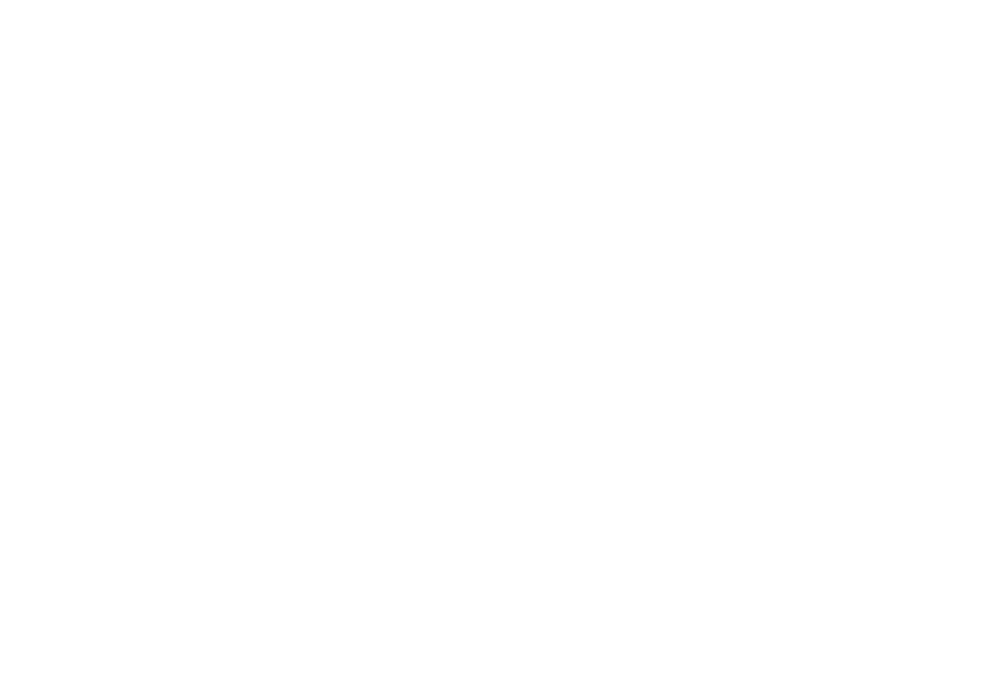

/tmp/ipykernel_1922763/2764369821.py:4: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse = Ellipse(xy=(0, 0), width=30, height=30,


(-80.0, 80.0)

In [16]:
fig_morph, ax_morph = plt.subplots(figsize=(10, 7))
mf.plot_cell(eva_extra.cell_model, eva_extra.sim, param_values=params_release, color_ais="g",
             color_axon="b", exclude_sections=["soma"], detailed=True, ax=ax_morph)
ellipse = Ellipse(xy=(0, 0), width=30, height=30, 
                  edgecolor="grey", color="grey", lw=2)
ax_morph.add_patch(ellipse)


ax_morph = mu.plot_mea_recording(eap_exp, probe, vscale=vscale, lw=1, ax=ax_morph)
ax_morph.get_lines()[-1].set_label("EXP")

ax_morph = mu.plot_mea_recording(eap_soma, probe, ax=ax_morph, vscale=vscale, 
                                 colors="C0", lw=1)
ax_morph.get_lines()[-1].set_label("SOMA")

ax_morph = mu.plot_mea_recording(eap_all, probe, ax=ax_morph, vscale=vscale, 
                                 colors="C1", lw=1)
ax_morph.get_lines()[-1].set_label("ALL")

ax_morph.set_xlim(-110, 110)
ax_morph.set_ylim(-80, 80)


In [17]:
ais_location = [-48, 5, 0]
basal_location = [-92, 11, 0]
soma_location = [0, 0, 0]

position_names = ["soma", "basal", "ais"]
positions = [soma_location, basal_location, ais_location]

best_params = opt_results_validation["soma"]["params"]

extra_recordings = mf.utils.extra_recordings_from_positions(eva_extra.cell_model, 
                                                            eva_extra.sim, params=best_params,
                                                            position_names=position_names,
                                                            positions=positions,
                                                            with_currents=True)

Found position: [0 0 0] in seclist somatic
Found position: [-92  11   0] in seclist basal
Found position: [-48   5   0] in seclist axon_initial_segment


In [18]:
colors_pos = {
    "soma": "C3",
    "ais": "C4",
    "basal": "C5",
}

In [19]:
for i, (pos_name, pos) in enumerate(zip(position_names, positions)):
    pos_tip = np.array(pos[:2])
    x = np.array([pos_tip, pos_tip + [50, 50], pos_tip + [48, 52]])
    t = plt.Polygon(x, color=colors_pos[pos_name], label=pos_name)
    ax_morph.add_patch(t)
ax_morph.legend(fontsize=18)


In [20]:
eva_extra = mf.create_evaluator(
    model_name=model_name,
    strategy="all",
    protocols_with_lfp=protocol_for_eap,
    abd=abd,
    extra_recordings={"IDrest_250": extra_recordings},
    **extra_kwargs
)

Setting 'extracellularmech' to True for extra_recordings


In [21]:
responses_extra = eva_extra.run_protocol(eva_extra.fitness_protocols["IDrest_250"], best_params)

In [22]:
responses_extra_cut = mf.utils.get_peak_cutout(responses_extra, ms_before=extra_kwargs["ms_cut"][0], 
                                               ms_after=extra_kwargs["ms_cut"][1], average=True)

In [23]:
eap_soma =  opt_results_validation["soma"]["eap"]
eap_all =  opt_results_validation["all"]["eap"]

<IPython.core.display.Javascript object>


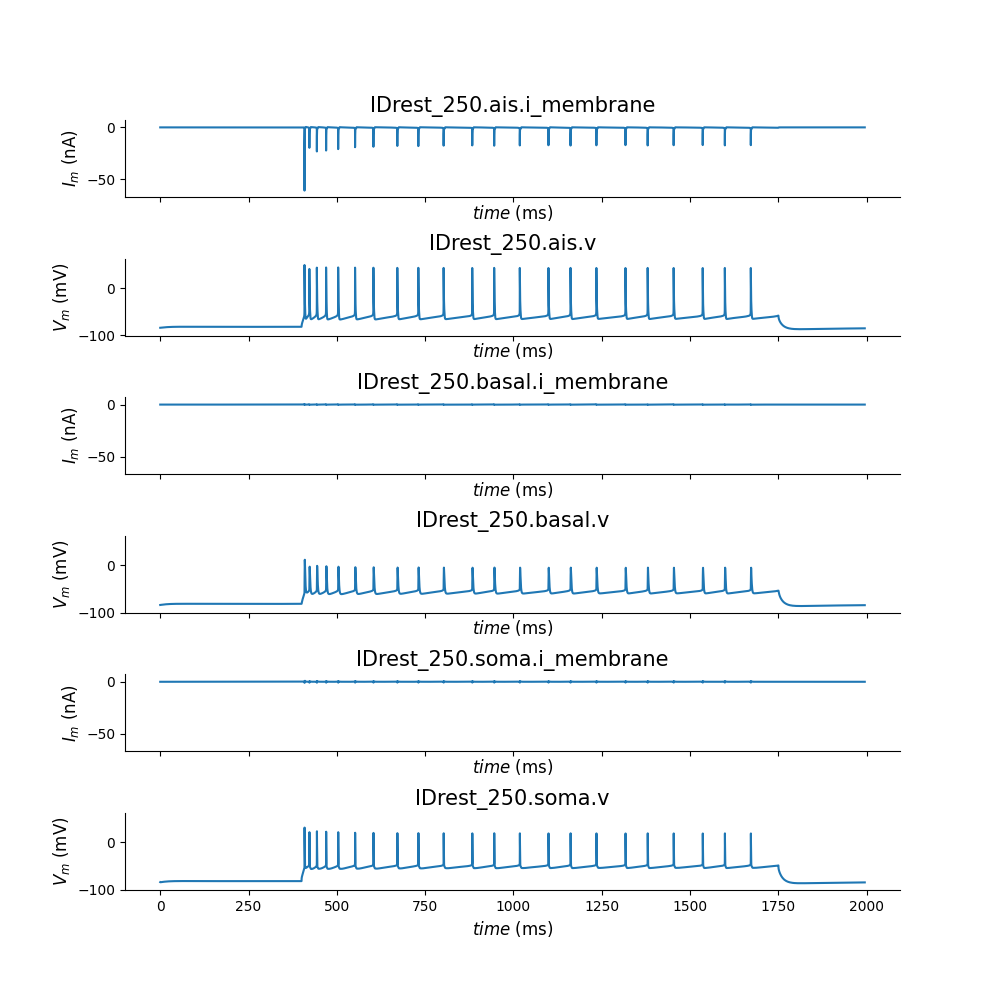

In [24]:
mf.plot_responses(responses_extra)

<IPython.core.display.Javascript object>


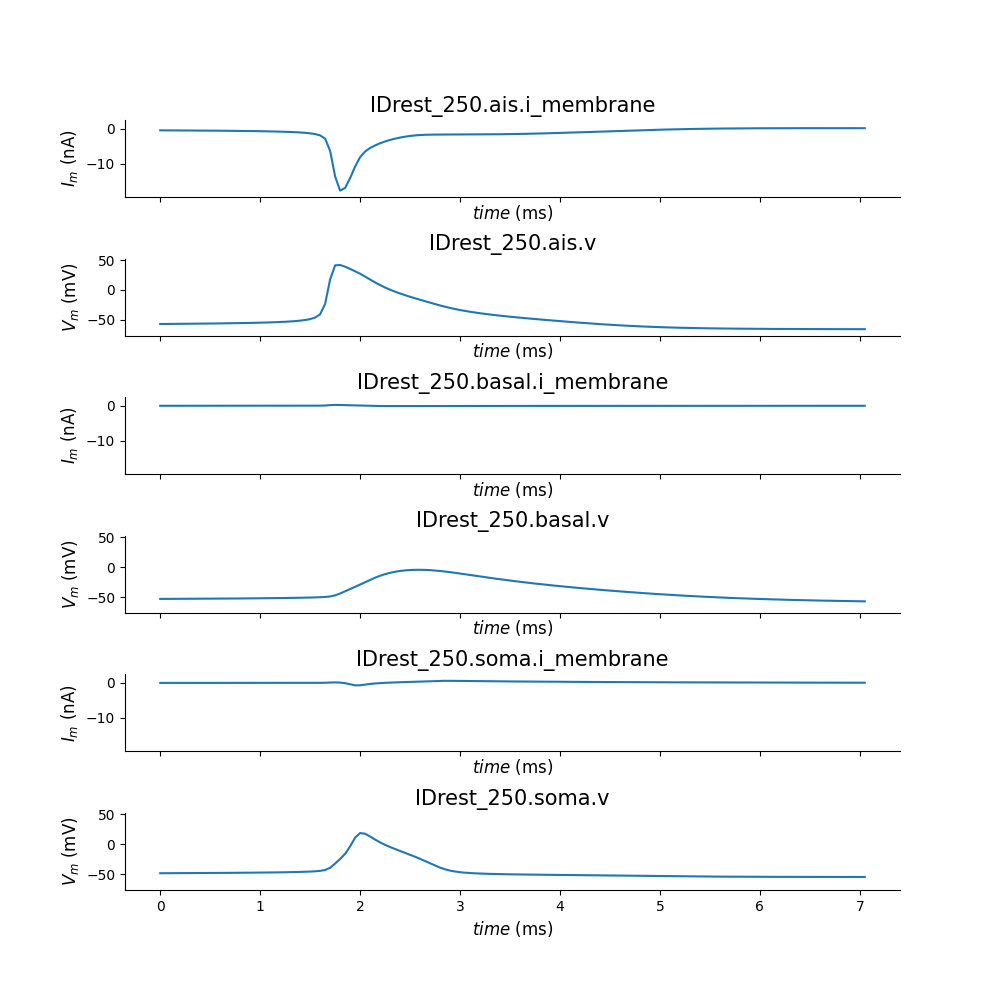

In [25]:
mf.plot_responses(responses_extra_cut)

<IPython.core.display.Javascript object>


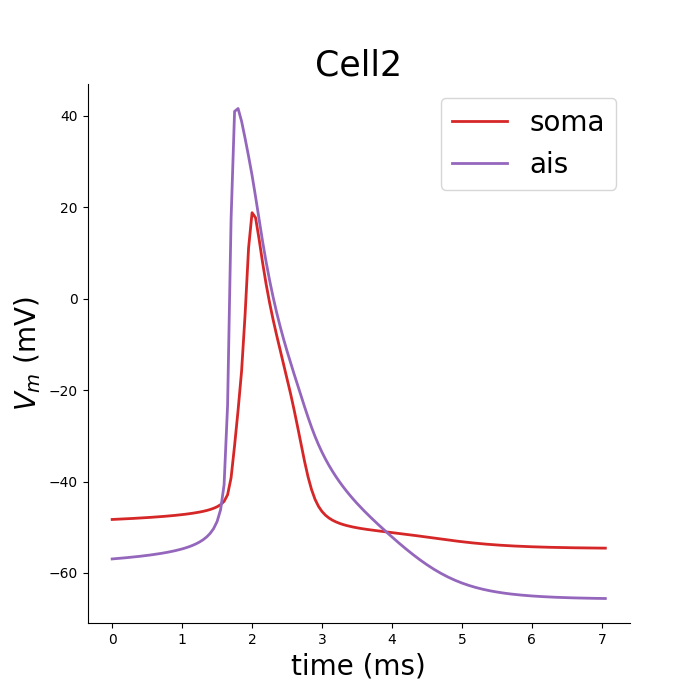

In [27]:
# Show that AP starts at AIS
fig_v, ax_v = plt.subplots(figsize=(7, 7))

v_ais = responses_extra_cut["IDrest_250.ais.v"]
v_soma = responses_extra_cut["IDrest_250.soma.v"]


ax_v.plot(v_soma["time"], v_soma["voltage"], colors_pos["soma"], label="soma", lw=2)
ax_v.plot(v_ais["time"], v_ais["voltage"], colors_pos["ais"], label="ais", lw=2)

ax_v.legend(fontsize=20)
ax_v.set_ylabel("$V_m$ (mV)", fontsize=20)
ax_v.set_xlabel("time (ms)", fontsize=20)
ax_v.set_title("Cell2", fontsize=25)

ax_v.spines["top"].set_visible(False)
ax_v.spines["right"].set_visible(False)

<IPython.core.display.Javascript object>


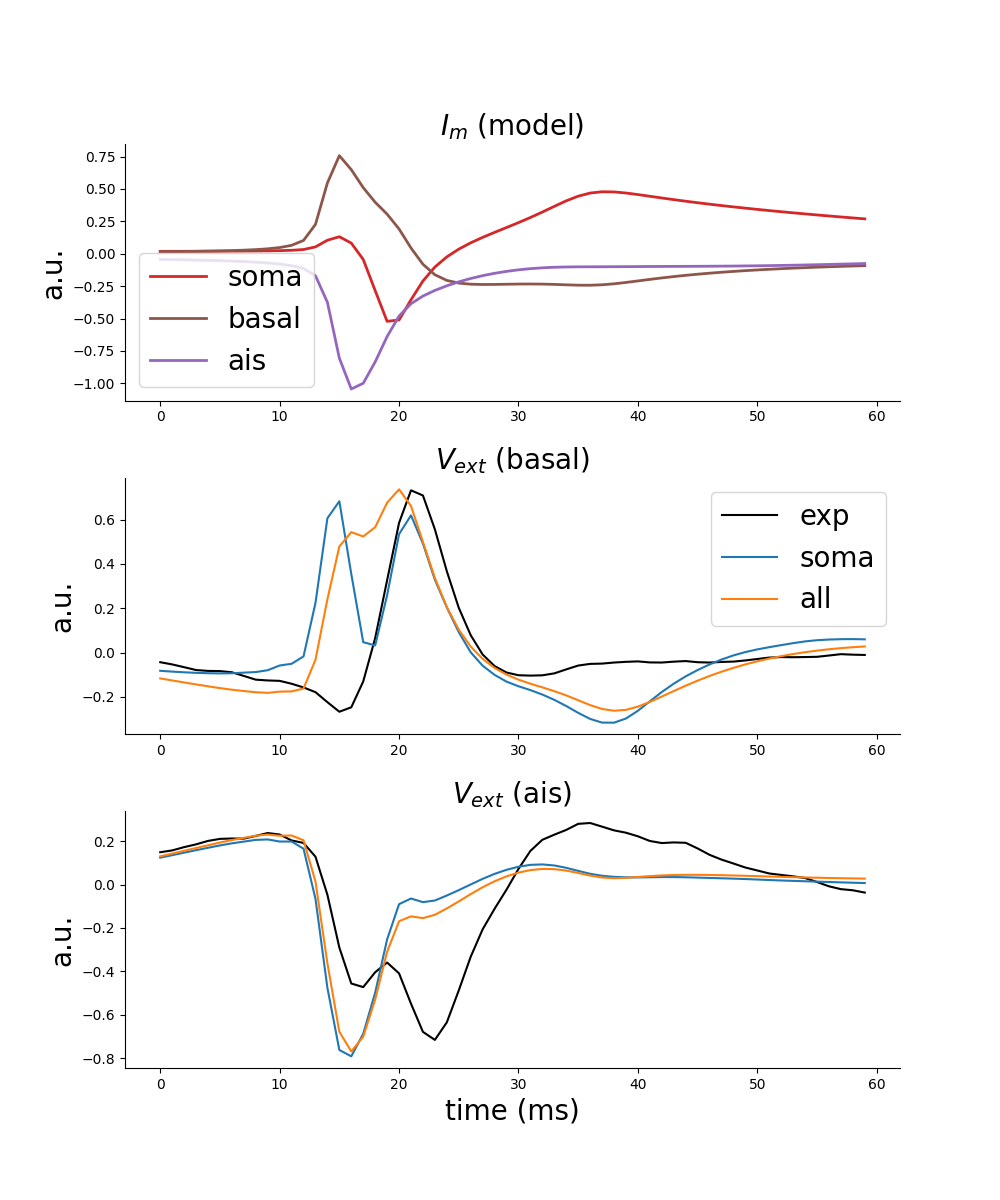

In [28]:
# Show that AP starts at AIS
fig_c, ax_c = plt.subplots(nrows=3, figsize=(10, 12))

elec_idx_basal = np.argmin([np.linalg.norm(basal_location - p) for p in probe.positions])
elec_idx_ais = np.argmin([np.linalg.norm(ais_location - p) for p in probe.positions])


time_idxs = slice(20, 80)

i_ais = responses_extra_cut["IDrest_250.ais.i_membrane"]["current"]
i_soma = responses_extra_cut["IDrest_250.soma.i_membrane"]["current"]
i_basal = responses_extra_cut["IDrest_250.basal.i_membrane"]["current"]


ax_c[0].plot(i_soma[time_idxs] / np.ptp(i_soma[time_idxs]), colors_pos["soma"], label="soma", lw=2)
ax_c[0].plot(i_basal[time_idxs] / np.ptp(i_basal[time_idxs]), colors_pos["basal"], label="basal", lw=2)
ax_c[0].plot(i_ais[time_idxs] / np.ptp(i_ais[time_idxs]), colors_pos["ais"], label="ais", lw=2)


ax_c[1].plot(eap_exp[elec_idx_basal, time_idxs] / np.ptp(eap_exp[elec_idx_basal, time_idxs]), 
             color="k", label="exp")
ax_c[1].plot(eap_soma[elec_idx_basal, time_idxs] / np.ptp(eap_soma[elec_idx_basal, time_idxs]), 
             color="C0", label="soma")
ax_c[1].plot(eap_all[elec_idx_basal, time_idxs] / np.ptp(eap_all[elec_idx_basal, time_idxs]), 
             color="C1", label="all")


ax_c[2].plot(eap_exp[elec_idx_ais, time_idxs] / np.ptp(eap_exp[elec_idx_ais, time_idxs]), 
             color="k", label="exp")
ax_c[2].plot(eap_soma[elec_idx_ais, time_idxs] / np.ptp(eap_soma[elec_idx_ais, time_idxs]), 
             color="C0", label="soma")
ax_c[2].plot(eap_all[elec_idx_ais, time_idxs] / np.ptp(eap_all[elec_idx_ais, time_idxs]), 
             color="C1", label="all")


ax_c[0].legend(fontsize=20)
ax_c[0].set_ylabel("a.u.", fontsize=20)
ax_c[0].set_title("$I_m$ (model)", fontsize=20)

ax_c[1].legend(fontsize=20)
ax_c[1].set_ylabel("a.u.", fontsize=20)
ax_c[1].set_title("$V_{ext}$ (basal)", fontsize=20)

ax_c[2].set_title("$V_{ext}$ (ais)", fontsize=20)
ax_c[2].set_ylabel("a.u.", fontsize=20)
ax_c[2].set_xlabel("time (ms)", fontsize=20)

for ax in ax_c.flatten():
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

fig_c.subplots_adjust(hspace=0.3)

In [29]:
# save fig
save_fig = True
fig_folder = Path("../../figures")

if save_fig:
    fig_folder.mkdir(exist_ok=True)

In [30]:
fig_morph.savefig(fig_folder / f"figS2_{model_name}-extra-rec.pdf")
fig_v.savefig(fig_folder / f"figS3_{model_name}-AP.pdf")
fig_c.savefig(fig_folder / f"figS4_{model_name}-Im-contrib.pdf")